# COVID-19 Health Policies
*** For specific Countries ***
(Australia, Senegal, Egypt, China)


## Import required modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Read in data

In [2]:
# Read in the data
epi_data = pd.read_csv("https://storage.googleapis.com/covid19-open-data/v2/epidemiology.csv", 
                       keep_default_na=False, na_values=[""], parse_dates=['date'], index_col=['date'])

gr_data = pd.read_csv("https://storage.googleapis.com/covid19-open-data/v2/oxford-government-response.csv",
                      keep_default_na=False, na_values=[""], parse_dates=['date'], index_col=['date'])

## Get Specific Country Dataframes to work with
* Need epidemiology dataframe for each country
* Need government response dataframe for each country

In [3]:
# Country Codes 
# Can be found by googling "ISO 3166-1 for *countryName*"
# Australia - 'AU'
# United States - 'US'
# Senegal - 'SN'
# China - 'CN'
# Egypt - 'EG'

# epidemiology data consists of the following columns
# date, key, new_confirmed, new_deceased, new_recovered, new_tested, total_confirmed, total_deceased,
# total_recovered, total_tested

start_remove = ('2019-12-30')
end_remove = ('2019-12-31')
epi_data = epi_data.loc[(epi_data.index < start_remove) | (epi_data.index > end_remove)]

us_epi_df = epi_data[(epi_data.key) == 'US']
au_epi_df = epi_data[(epi_data.key) == 'AU']
sn_epi_df = epi_data[(epi_data.key) == 'SN']
eg_epi_df = epi_data[(epi_data.key) == 'EG']
cn_epi_df = epi_data[(epi_data.key) == 'CN']

# government response data consists of many columns. Can see them here
# https://github.com/OxCGRT/covid-policy-tracker/blob/master/documentation/codebook.md#containment-and-closure-policies
us_gr_df = gr_data[(gr_data.key) == 'US']
au_gr_df = gr_data[(gr_data.key) == 'AU']
sn_gr_df = gr_data[(gr_data.key) == 'SN']
eg_gr_df = gr_data[(gr_data.key) == 'EG']
cn_gr_df = gr_data[(gr_data.key) == 'CN']

# Can visualize the data frames
# display(us_epi_df)

# Create necessary Data for Plotting

In [4]:
# Takes the values from 'new_confirmed' cases and creates a new column holding the 7 day rolling average
pd.options.mode.chained_assignment = None  # default='warn'
us_epi_df['rolling_cases'] = us_epi_df['new_confirmed'].rolling(7).mean()
au_epi_df['rolling_cases'] = au_epi_df['new_confirmed'].rolling(7).mean()
sn_epi_df['rolling_cases'] = sn_epi_df['new_confirmed'].rolling(7).mean()
eg_epi_df['rolling_cases'] = eg_epi_df['new_confirmed'].rolling(7).mean()
cn_epi_df['rolling_cases'] = cn_epi_df['new_confirmed'].rolling(7).mean()

In [5]:
def plot_health_policies(epi_data, gr_data, country):
    fig = plt.figure(1, figsize=(15, 7))
    ax = fig.add_subplot(111)
    ax.set(xlabel='Month',
           ylabel='New Daily Cases',
           title=country + ' Health Policies vs Cases')

    ax.plot(epi_data.index.values,
            epi_data['rolling_cases'],
            color='blue',
            label='New Daily Cases (7-day avg)')

    ax2 = ax.twinx()
    ax2.plot(gr_data.index.values,
            gr_data['testing_policy'],
            color='red',
            label='Testing Policy [0-3]')

    ax2.plot(gr_data.index.values,
            gr_data['contact_tracing'],
            color='orange',
            label='Contact Tracing [0-2]')

    handles,labels = [],[]
    for ax in fig.axes:
        for h,l in zip(*ax.get_legend_handles_labels()):
            handles.append(h)
            labels.append(l)

    ax.set_xlim([dt.date(2020, 1, 1), dt.date(2020, 12, 1)])
    plt.legend(handles,labels)
    plt.show()
    
def plot_containment_policies(epi_data, gr_data, country):
    fig = plt.figure(1, figsize=(15, 7))
    ax = fig.add_subplot(111)
    ax.set(xlabel='Month',
           ylabel='New Daily Cases',
           title=country + ' Containment Policies vs Cases')

    ax.plot(epi_data.index.values,
            epi_data['rolling_cases'],
            color='blue',
            label='New Daily Cases (7-day avg)')

    ax2 = ax.twinx()
    ax2.plot(gr_data.index.values,
            gr_data['restrictions_on_gatherings'],
            color='red',
            label='Gather Restrictions [0-4]')

    ax2.plot(gr_data.index.values,
            gr_data['workplace_closing'],
            color='orange',
            label='Workplace Closing [0-3]')

    ax2.plot(gr_data.index.values,
            gr_data['school_closing'],
            color='purple',
            label='School Closing [0-3]')

    ax2.plot(gr_data.index.values,
            gr_data['stay_at_home_requirements'],
            color='yellow',
            label='Stay at Home [0-3]]')

    handles,labels = [],[]
    for ax in fig.axes:
        for h,l in zip(*ax.get_legend_handles_labels()):
            handles.append(h)
            labels.append(l)

    ax.set_xlim([dt.date(2020, 1, 1), dt.date(2020, 12, 1)])
    plt.legend(handles,labels)
    plt.show()

# Plot United States Policies vs Cases
- Health Policies
    - Testing Policy
    - Contact Tracing Policy
- Containment Policies
    - Stay at Home Policy
    - Restriction on Public Gatherings Policy
    - Workplace Closing Policy
    - School Closing Policy

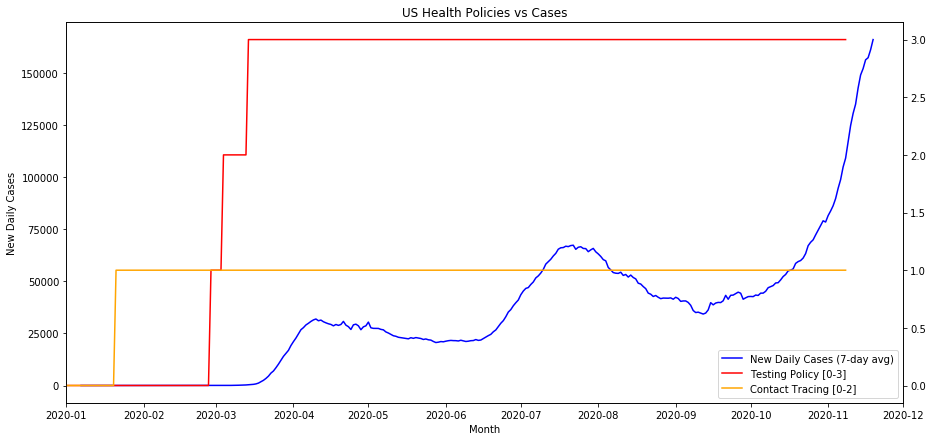

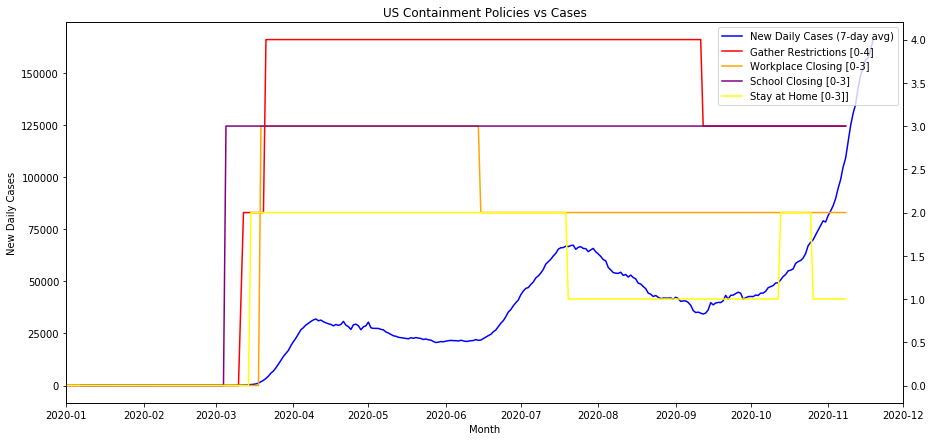

In [6]:
plot_health_policies(us_epi_df, us_gr_df, 'US')
plot_containment_policies(us_epi_df, us_gr_df, 'US')

# Plot Australia Policies vs Cases
- Health Policies
    - Testing Policy
    - Contact Tracing Policy
- Containment Policies
    - Stay at Home Policy
    - Restriction on Public Gatherings Policy
    - Workplace Closing Policy
    - School Closing Policy

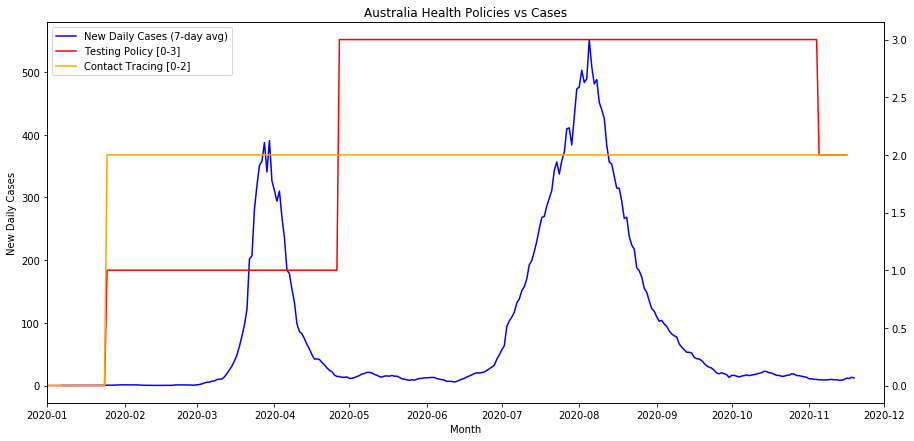

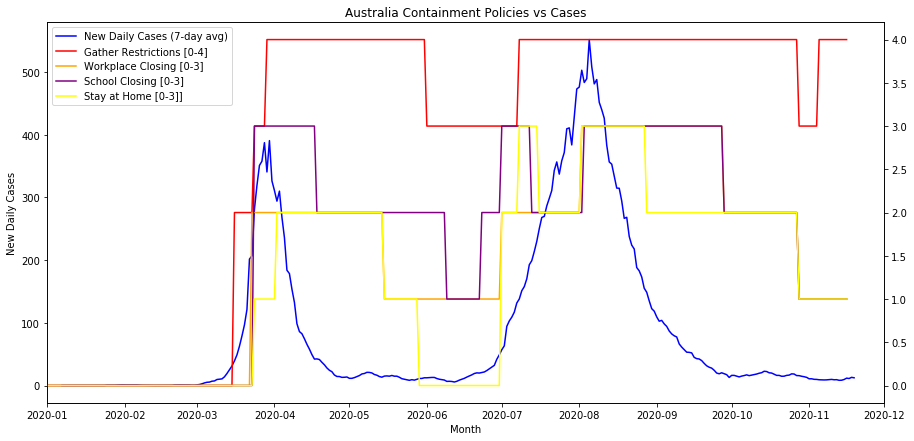

In [7]:
plot_health_policies(au_epi_df, au_gr_df, 'Australia')
plot_containment_policies(au_epi_df, au_gr_df, 'Australia')

# Plot Senegal Policies vs Cases
- Health Policies
    - Testing Policy
    - Contact Tracing Policy
- Containment Policies
    - Stay at Home Policy
    - Restriction on Public Gatherings Policy
    - Workplace Closing Policy
    - School Closing Policy

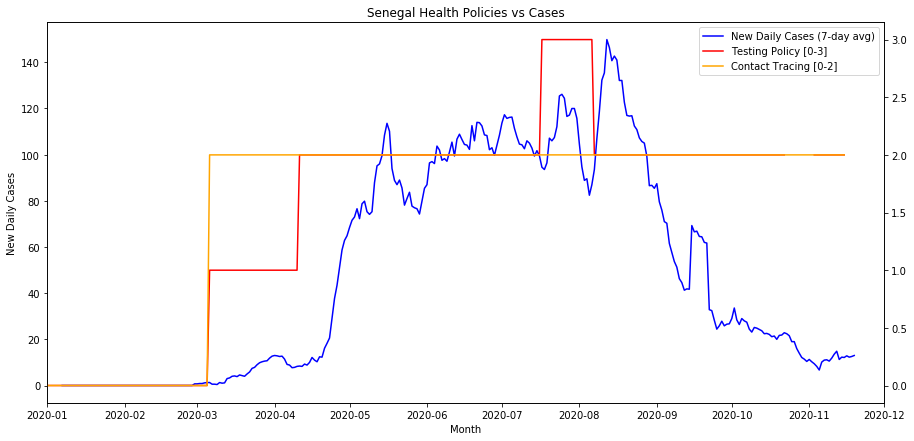

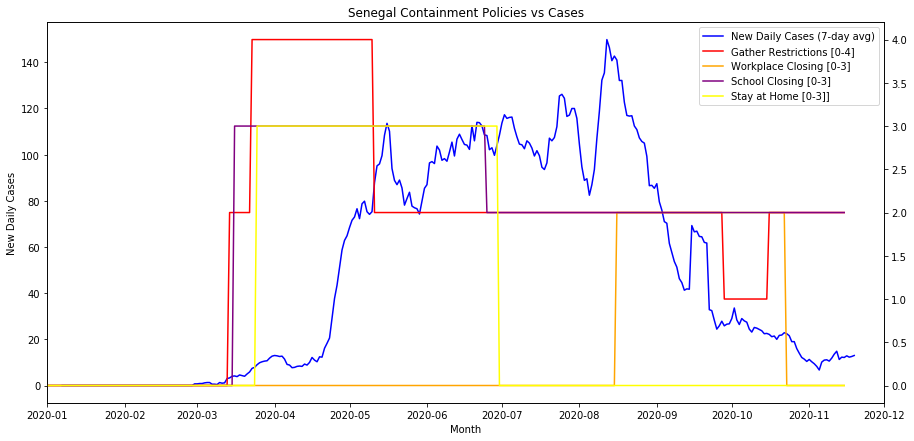

In [8]:
plot_health_policies(sn_epi_df, sn_gr_df, 'Senegal')
plot_containment_policies(sn_epi_df, sn_gr_df, 'Senegal')

# Plot Egypt Policies vs Cases
- Health Policies
    - Testing Policy
    - Contact Tracing Policy
- Containment Policies
    - Stay at Home Policy
    - Restriction on Public Gatherings Policy
    - Workplace Closing Policy
    - School Closing Policy

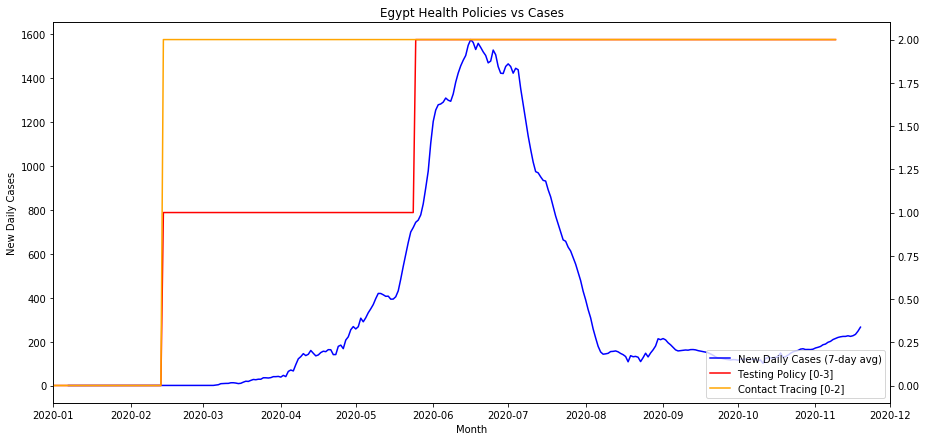

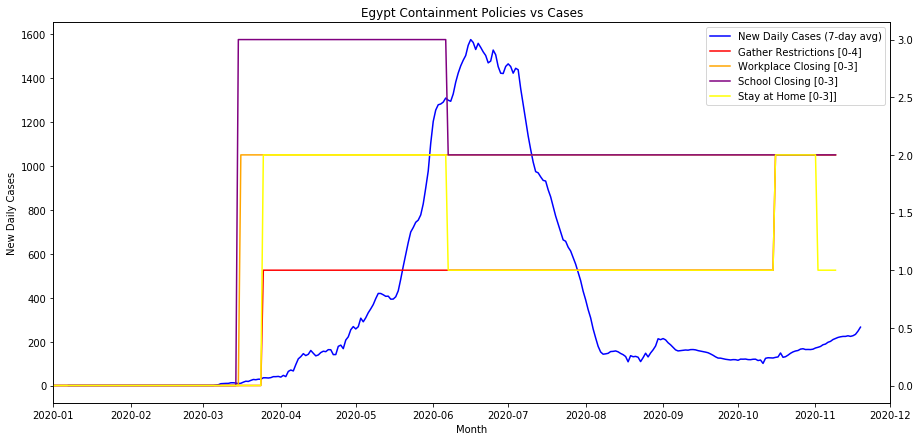

In [9]:
plot_health_policies(eg_epi_df, eg_gr_df, 'Egypt')
plot_containment_policies(eg_epi_df, eg_gr_df, 'Egypt')

# Plot China Policies vs Cases
- Health Policies
    - Testing Policy
    - Contact Tracing Policy
- Containment Policies
    - Stay at Home Policy
    - Restriction on Public Gatherings Policy
    - Workplace Closing Policy
    - School Closing Policy

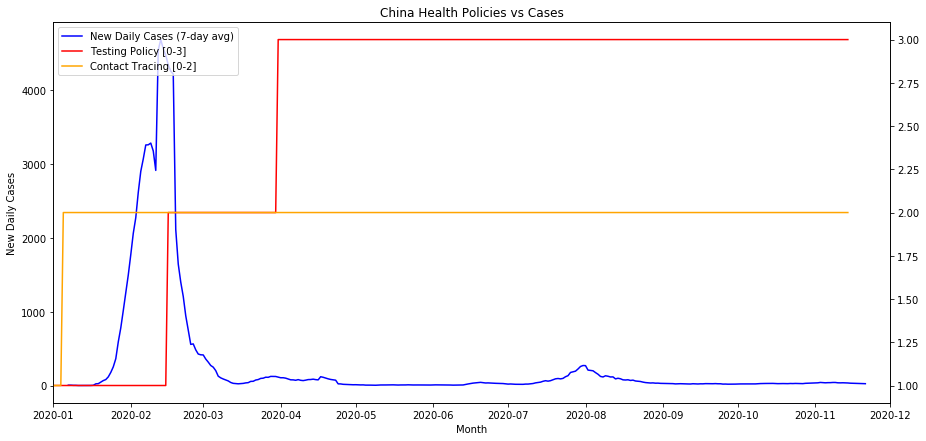

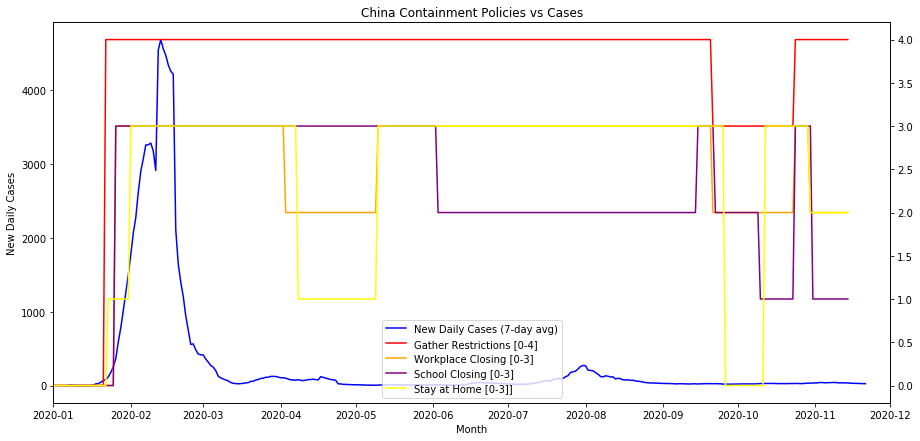

In [10]:
plot_health_policies(cn_epi_df, cn_gr_df, 'China')
plot_containment_policies(cn_epi_df, cn_gr_df, 'China')